In [60]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler as mms

import tensorflow
import keras
import tensorflow.keras

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, SimpleRNN

print(f"Numpy version : {np.__version__}")
print(f"Python Version: {sys.version}")
print(f"Tensor Flow Version: {tensorflow.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print(f"Keras Version: {keras.__version__}")

np.random.seed(1)
tensorflow.random.set_seed(5)

Numpy version : 1.20.3
Python Version: 3.7.11 (default, Jul 27 2021, 09:42:29) [MSC v.1916 64 bit (AMD64)]
Tensor Flow Version: 2.0.0
Keras Version: 2.2.4-tf
Keras Version: 2.3.1


In [61]:
normalizer = mms(feature_range=(0,1))

base_data = pd.read_csv('petr4_treinamento.csv')
test_data = pd.read_csv('petr4_teste.csv')
base_data = base_data.dropna()

base_data = base_data.drop(['Open', 'High', 'Low', 'Adj Close'], 1)
base_data = base_data.iloc[:, 1:3].values

print(f'Base data: {type(base_data)}, {base_data.shape}')

train_data = normalizer.fit_transform(base_data)
print(train_data[0:5])

test_data = test_data.drop(['Open', 'High', 'Low', 'Adj Close'], 1)
test_data = test_data.iloc[:, 1:3].values

print(f'Test data: {type(test_data)}, {test_data.shape}')

full_data = np.concatenate((base_data, test_data), axis=0)
print(full_data.shape)

Base data: <class 'numpy.ndarray'>, (1258, 2)
[[0.19275309 0.20620253]
 [0.16286889 0.32613739]
 [0.15240942 0.35250878]
 [0.16697797 0.35586938]
 [0.18789691 0.34661306]]
Test data: <class 'numpy.ndarray'>, (20, 2)
(1278, 2)


C:\Users\felip\miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  import sys
C:\Users\felip\miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  from ipykernel import kernelapp as app


In [62]:
def build_modelLSTM():
    model = Sequential([LSTM(units=100, return_sequences=True),
                        Dropout(0.3),
                        LSTM(units=50, return_sequences=False),
                        Dropout(0.3),
                        Dense(1, activation='linear')])
    model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['mean_absolute_error'])
    return model

def build_previsores(data, start):
    previsores = []
    preco_real = []

    for i in range(start, len(data)):
        previsores.append(data[i-start:i, :])
        preco_real.append(data[i, :1]) 
    
    previsores, preco_real = np.array(previsores), np.array(preco_real)
    
    return previsores, preco_real

def build_test_previsores(data, fdata, start):
    previsores = []
    inputs = full_data[len(fdata) - len(data) - start:]
    inputs = inputs.reshape(-1,data.shape[1])
    inputs = normalizer.transform(inputs)
    
    for j in range(start, len(inputs)):
        previsores.append(inputs[j-start:j,:])
    
    previsores = np.array(previsores)

    return previsores


def desvio_medio(predict, original):
    return (((original.mean() - predict.mean()) / original.mean()) * 100)

def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')

    plt.plot(history.epoch, np.array(history.history['mae']), 'b-', label='Mean Absolute Error',)
    plt.plot(history.epoch, np.array(history.history['val_mae']), 'r-' , label='Validation MAE')

    plt.legend()
    plt.title('Erro médio absoluto da rede neural')
    plt.ylim([0, 1.30])
    plt.show()

def plot_predict(previsores, preco_real):
    plt.plot(preco_real, color = 'red', label = 'Preço Real')
    plt.plot(previsores, color = 'blue', label = 'Valor Previsto')
    plt.title('Previsor de Preços de Ações')
    plt.xlabel('Dia')
    plt.ylabel('Valor [R$]')
    plt.legend()
    plt.show()

class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0 and epoch > 0: print('') #'\n'
        print('.', end='')

In [63]:
previsores = [[],[],[]]
test_previsores = [[],[],[]]
preco_real = [[],[],[]]

initial = 60
start = initial
for i in range(len(previsores)):
    previsores[i],  preco_real[i]  = build_previsores(train_data,  start)  
    start += initial

start = initial
for i in range(len(test_previsores)):
    test_previsores[i] = build_test_previsores(test_data, full_data, start)
    start += initial
    
for i in range(len(previsores)):
    print(previsores[i].shape)
    print(test_previsores[i].shape)

(1198, 60, 2)
(20, 60, 2)
(1138, 120, 2)
(20, 120, 2)
(1078, 180, 2)
(20, 180, 2)


In [64]:
predictionlist = []

keras.backend.clear_session()

for i in range(len(previsores)):
    print(f'Treinamento: {i+1}')
    model = build_modelLSTM()
    model.fit(previsores[i], preco_real[i], epochs=100, batch_size=512, validation_split=0.3, verbose=0, callbacks=[PrintDot()])

    prediction = model.predict(test_previsores[i])

    prediction = normalizer.inverse_transform(prediction)
    predictionlist.append(prediction)

    print('\n')

    del prediction
    del model
    keras.backend.clear_session()

Treinamento: 1
....................................................................................................

Treinamento: 2
....................................................................................................

Treinamento: 3
....................................................................................................



In [65]:
start = initial
print(f'Média dos preços reais: R${test_data[:, 0].mean(): .2f}')
for i in range(len(predictionlist)):
    print(f'Média das previsões com {start} dados anteriores: R${predictionlist[i][0][0].mean(): .2f}, Desvio médio: {desvio_medio(predictionlist[i][0][0], test_data[:, 0]): .4f}%')
    start+=initial

Média dos preços reais: R$ 29.15
Média das previsões com 60 dados anteriores: R$ 27.24, Desvio médio:  6.5613%
Média das previsões com 120 dados anteriores: R$ 28.00, Desvio médio:  3.9443%
Média das previsões com 180 dados anteriores: R$ 29.00, Desvio médio:  0.5169%


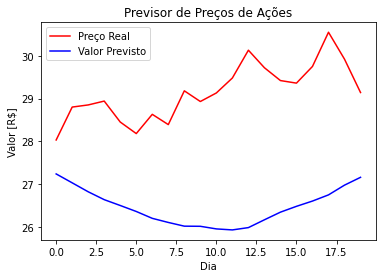

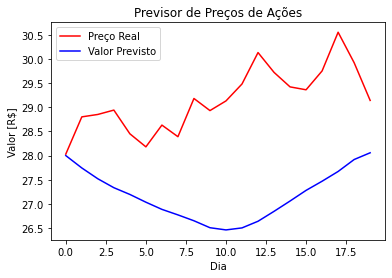

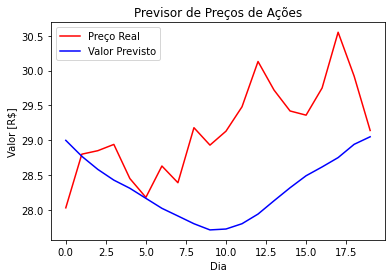

In [71]:
for i in range(len(predictionlist)):
    predlist = []
    for e in range(test_previsores[i].shape[0]):
        predlist.append(predictionlist[i][e][0])
    plot_predict(predlist, test_data[:, 0])
